<a href="https://colab.research.google.com/github/emkalan/comp215/blob/main/labs/lab05_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 5
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * apply both a direct (ie. brute force) and heuristic algorithm to a problem
  * use the networkx module to visualize graphs
  * measure algorithm scaling


During this lab, you will be introduced to the following:
  * seeding the random module



## The Traveling Salesperson Problem

This lab is based on the famous Traveling Salesperson Problem (TSP) outlined in Section 3.3.2 of 'On Complexity'.  Imagine you needed to travel to ten different cities.  What is the sortest possible route you could take to visit every city?  For our version of the problem, you start from a specific city and must end on the same city.

In this lab, you will implement a direct (ie. brute force) and a heuristic solution to the problem.

In [1]:
# start with some imports
import random, math, time, itertools
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

## Set up the map

For this implementation of the problem we will randomly place N cities on a 100 by 100 grid.  Cities will be labelled using a single character; 'A', 'B', 'C', etc.  City locations will be denoted by a 2-tuple, `(x,y)`, giving their position on the grid. In order to create reproducable maps, we will use [random.seed()](https://docs.python.org/3/library/random.html#random.seed) to initialize the random module.  

In [2]:
def setup_map(N, seed=1):
  ''' Returns a map of N cities with random locations on a 100 by 100 grid '''
  random.seed(seed)
  city_locations = [(random.randint(0, 100), random.randint(0, 100)) for i in range(N)]
  city_names = [chr(65 + i) for i in range(N)]
  city_map = dict(zip(city_names, city_locations))
  return city_map

def graph_map(city_map):
  ''' graph the map of cities using networkx'''
  G = nx.Graph()
  G.add_nodes_from(city_map)
  nx.draw(G, city_map, with_labels=True)

def distance(city1, city2, city_map):
  ''' Returns the distance between two cities on a map'''
  x1, y1 = city_map[city1]
  x2, y2 = city_map[city2]
  return round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2),1)

def calculate_distances(city_map):
  ''' Returns a dictionary with the distances between all pairs of cities in a map '''
  distances = {}
  for city1 in city_map:
      for city2 in city_map:
          if city1 != city2:
              # this will have duplicate distances (A,B) and (B,A)
              # these duplicates make the algorithm implememntation simpler
              distances[(city1, city2)] = distance(city1, city2, city_map)
  return distances


City Map: {'A': (17, 72), 'B': (97, 8), 'C': (32, 15), 'D': (63, 97), 'E': (57, 60), 'F': (83, 48), 'G': (100, 26), 'H': (12, 62), 'I': (3, 49), 'J': (55, 77)}
Distances between cities: {('A', 'B'): 102.4, ('A', 'C'): 58.9, ('A', 'D'): 52.4, ('A', 'E'): 41.8, ('A', 'F'): 70.2, ('A', 'G'): 94.9, ('A', 'H'): 11.2, ('A', 'I'): 26.9, ('A', 'J'): 38.3, ('B', 'A'): 102.4, ('B', 'C'): 65.4, ('B', 'D'): 95.3, ('B', 'E'): 65.6, ('B', 'F'): 42.4, ('B', 'G'): 18.2, ('B', 'H'): 100.7, ('B', 'I'): 102.6, ('B', 'J'): 80.8, ('C', 'A'): 58.9, ('C', 'B'): 65.4, ('C', 'D'): 87.7, ('C', 'E'): 51.5, ('C', 'F'): 60.7, ('C', 'G'): 68.9, ('C', 'H'): 51.1, ('C', 'I'): 44.7, ('C', 'J'): 66.1, ('D', 'A'): 52.4, ('D', 'B'): 95.3, ('D', 'C'): 87.7, ('D', 'E'): 37.5, ('D', 'F'): 52.9, ('D', 'G'): 80.1, ('D', 'H'): 61.9, ('D', 'I'): 76.8, ('D', 'J'): 21.5, ('E', 'A'): 41.8, ('E', 'B'): 65.6, ('E', 'C'): 51.5, ('E', 'D'): 37.5, ('E', 'F'): 28.6, ('E', 'G'): 54.8, ('E', 'H'): 45.0, ('E', 'I'): 55.1, ('E', 'J'): 17.1,

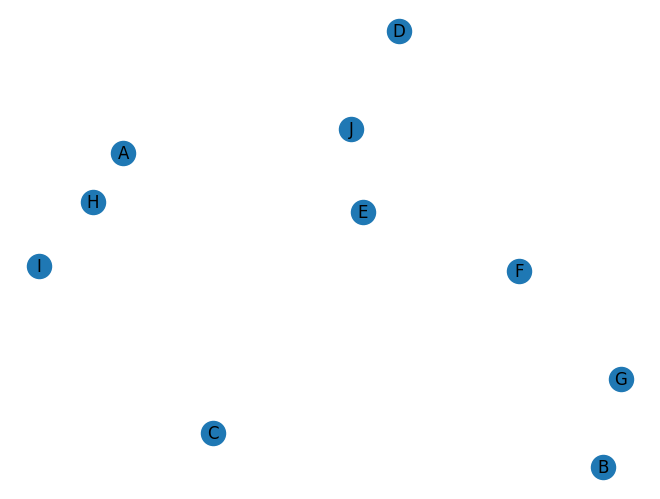

In [3]:
# test our setup functions
city_map = setup_map(10)
print(f'City Map: {city_map}')
distances = calculate_distances(city_map)
print(f'Distances between cities: {distances}')
graph_map(city_map)

### Exercise 1: The Brute Force Solution

Implement a brute force solution to the traveling salesman problem using the city map and distance dictionary given above.  The algorithm for the brute force solution looks something like this:
 1. Loop over every possible route that starts and ends on city A.  For a three city example, this would be ABCA, ACBA.  
 2. Calculate the total distance of each possible route.  
 3. Find the route with the minimum total distance.

Before you start coding, think about what functions and/or class you might want to simplify your implementation of the algorithm.  Write a small test for your algorithm.

In [23]:
# Ex. 1 your solution here
from itertools import permutations

def brute_force(city_map, distances):
    """
    Finds the shortest route using brute force. It has (O(n!)) complexity. Which is not ideal.
    For a city with fewer than 10 cities, this is fine. Any more and it will take a very long time.
    Ergo this is only a proof of concept.

    Args:
        city_map: A dictionary mapping city names to their coordinates.
        distances: A dictionary containing distances between cities.

    Returns:
        A tuple containing the shortest route and its total distance.
    """
    cities = list(city_map.keys())
    start_city = cities[0]
    other_cities = cities[1:]

    min_distance = float('inf')  # init with infinity (a very big value!)
    best_route = None

    for route_permutation in permutations(other_cities):
        route = [start_city] + list(route_permutation) + [start_city]  # complete route
        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += distances[(route[i], route[i + 1])]

        if total_distance < min_distance:
            min_distance = total_distance
            best_route = route
    return best_route, min_distance

best_route, min_distance = brute_force(city_map, distances)
print("Shortest route:", best_route)
print("Total distance:", min_distance)
import unittest

class TestBruteForce(unittest.TestCase):

    def test_brute_force(self):
        # Define a simple city map and distance dictionary
        city_map = {
            'A': (0, 0),
            'B': (1, 1),
            'C': (2, 2),
            'D': (3, 3)
        }

        distances = {
            ('A', 'B'): 1.4, ('B', 'A'): 1.4,
            ('A', 'C'): 2.8, ('C', 'A'): 2.8,
            ('A', 'D'): 4.2, ('D', 'A'): 4.2,
            ('B', 'C'): 1.4, ('C', 'B'): 1.4,
            ('B', 'D'): 2.8, ('D', 'B'): 2.8,
            ('C', 'D'): 1.4, ('D', 'C'): 1.4
        }

        # Run the brute_force function
        best_route, min_distance = brute_force(city_map, distances)

        # Define expected result
        expected_route = ['A', 'B', 'C', 'D', 'A']
        expected_distance = 8.4  # A->B->C->D->A

        # Assertions
        self.assertEqual(best_route, expected_route)
        self.assertEqual(round(min_distance, 2), expected_distance)


suite = unittest.TestLoader().loadTestsFromTestCase(TestBruteForce)
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


Shortest route: ['A', 'D', 'J', 'E', 'F', 'G', 'B', 'C', 'I', 'H', 'A']
Total distance: 302.7


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Exercise 2: Nearest Neighbour

Implement a nearest neighbour solution to the traveling salesman problem using the city map and distance dictionary given above.  The algorithm for the nearest neighbour solution looks something like this:
 1. Start from the starting city.  
 2. Go to the nearest city that has not been visited.  
 3. Repeat steps 1 and 2 until all cities have been visited.

Before you start coding, think about what functions and/or class you might want to simplify your implementation of the algorithm.  Write a small test for your algorithm.

In [25]:
# Ex.2 your code here
def nearest_neighbour(city_map, distances):
  """
  Finds the shortest route using the nearest neighbour algorithm.

  Args:
      city_map: A dictionary mapping city names to their coordinates.
      distances: A dictionary containing distances between cities.

  Returns:
      A tuple containing the shortest route and its total distance.
  """
  cities = list(city_map.keys())
  start_city = cities[0]
  current_city = start_city
  visited_cities = [start_city]
  total_distance = 0
  while len(visited_cities) < len(cities):
      nearest_city = None
      min_distance = float('inf')
      for city in cities:
          if city not in visited_cities:
              distance = distances[(current_city, city)]
              if distance < min_distance:
                  min_distance = distance
                  nearest_city = city
      visited_cities.append(nearest_city)
      total_distance += min_distance
      current_city = nearest_city
      # close the loop
  visited_cities.append(start_city)
  total_distance += distances[(current_city, start_city)]
  return visited_cities, total_distance

nearest_neighbour(city_map, distances)

import unittest

class TestNearestNeighbour(unittest.TestCase):

    def test_nearest_neighbour(self):
        city_map = {
            'A': (0, 0),
            'B': (1, 1),
            'C': (3, 0),
        }

        distances = {
            ('A', 'B'): 1.4, ('B', 'A'): 1.4,
            ('A', 'C'): 3.0, ('C', 'A'): 3.0,
            ('B', 'C'): 2.2, ('C', 'B'): 2.2
        }

        route, distance = nearest_neighbour(city_map, distances)

        expected_route = ['A', 'B', 'C', 'A']
        expected_distance = 7  # or a reasonable approximation accounting for rounding

        self.assertEqual(route, expected_route)
        self.assertAlmostEqual(distance, expected_distance, delta=0.1)  # delta for rounding


suite = unittest.TestLoader().loadTestsFromTestCase(TestNearestNeighbour)
unittest.TextTestRunner().run(suite)

F
FAIL: test_nearest_neighbour (__main__.TestNearestNeighbour.test_nearest_neighbour)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-25-0865a074c33e>", line 60, in test_nearest_neighbour
    self.assertAlmostEqual(distance, expected_distance, delta=0.1)  # delta for rounding
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: 6.6 != 7 within 0.1 delta (0.40000000000000036 difference)

----------------------------------------------------------------------
Ran 1 test in 0.004s

FAILED (failures=1)


<unittest.runner.TextTestResult run=1 errors=0 failures=1>

### Exercise 3: Graph the Routes

Use the networkx module to create directed graphs of the routes (brute force and nearest neighbour).  Include the distances between the cities on the edges.  Run several different map setups with a different sizes (ie. number of cities).  Do the brute force (ie. direct) and nearest neighbour (ie. heuristic) algorithms always give the same solution?  Do you notice anything about the brute force solutions that suggests an alternative heuristic algorithm?


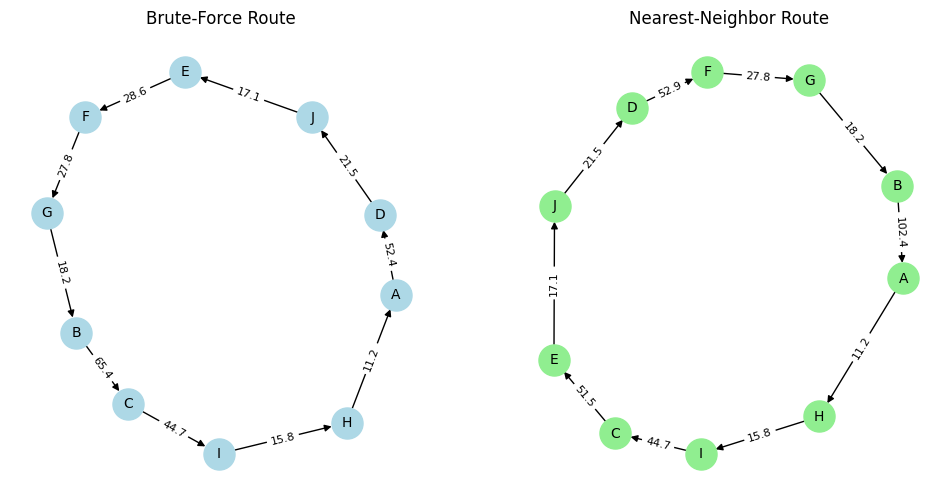

In [14]:
# Ex.3 your code here
import networkx as nx
import matplotlib.pyplot as plt

def graph_routes(city_map, distances, brute_force_route, nearest_neighbour_route):
  """
  Graphs the routes found by the brute-force and nearest-neighbor algorithms.

  Args:
    city_map: A dictionary mapping city names to their coordinates.
    distances: A dictionary containing distances between cities.
    brute_force_route: The route found by the brute-force algorithm.
      nearest_neighbour_route: The route found by the nearest-neighbor algorithm.
  """

  # Create directed graphs for both routes
  G_brute_force = nx.DiGraph()
  G_nearest_neighbour = nx.DiGraph()

  # Add nodes (cities) to the graphs
  G_brute_force.add_nodes_from(city_map.keys())
  G_nearest_neighbour.add_nodes_from(city_map.keys())

  # Add edges (routes) and edge labels (distances)
  for i in range(len(brute_force_route) - 1):
    city1 = brute_force_route[i]
    city2 = brute_force_route[i + 1]
    distance_between_cities = distances[(city1, city2)]
    G_brute_force.add_edge(city1, city2, weight=distance_between_cities)

  for i in range(len(nearest_neighbour_route) - 1):
    city1 = nearest_neighbour_route[i]
    city2 = nearest_neighbour_route[i + 1]
    distance_between_cities = distances[(city1, city2)]
    G_nearest_neighbour.add_edge(city1, city2, weight=distance_between_cities)

  # Create subplots for the two graphs
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Plot the brute-force route
  pos = nx.spring_layout(G_brute_force)  # Adjust layout as needed
  nx.draw(G_brute_force, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, ax=axes[0])
  edge_labels = nx.get_edge_attributes(G_brute_force, 'weight')
  nx.draw_networkx_edge_labels(G_brute_force, pos, edge_labels=edge_labels, font_size=8, ax=axes[0])
  axes[0].set_title("Brute-Force Route")

  # Plot the nearest-neighbor route
  pos = nx.spring_layout(G_nearest_neighbour)  # Adjust layout as needed
  nx.draw(G_nearest_neighbour, pos, with_labels=True, node_color='lightgreen', node_size=500, font_size=10, ax=axes[1])
  edge_labels = nx.get_edge_attributes(G_nearest_neighbour, 'weight')
  nx.draw_networkx_edge_labels(G_nearest_neighbour, pos, edge_labels=edge_labels, font_size=8, ax=axes[1])
  axes[1].set_title("Nearest-Neighbor Route")

  plt.show()
brute_force_route, _ = brute_force(city_map, distances)
nearest_neighbour_route, _ = nearest_neighbour(city_map, distances)
graph_routes(city_map, distances, best_route, nearest_neighbour_route)

### Exercise 4: Algorithm Scaling

Use the `time` module to measure the running time of the two algorithms.  Note that the `time.time()` function returns the current time, so calling it before and after the algorithm has run can give you the time it takes for the algorithm to execute.  Taking the average over several trials will make the measurement more precise.  Demonstrate the scaling nature of the algorithms by plotting their execution time as a function of N, up to about N = 10.  

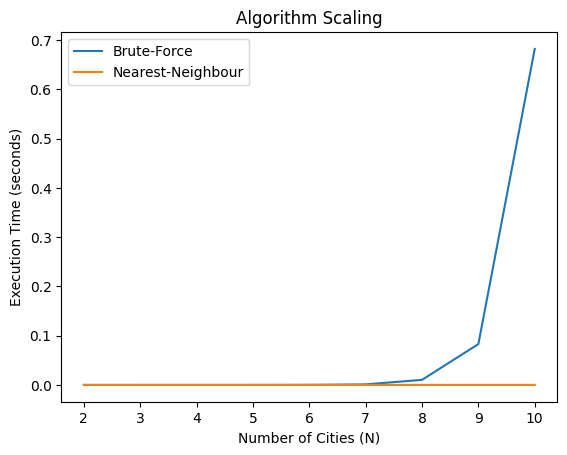

In [10]:
# Ex 4: your code here
time_brute_force = []
time_nearest_neighbour = []
N_values = range(2, 11)  # number of cities from 2 to 10

for N in N_values:
    city_map = setup_map(N)
    distances = calculate_distances(city_map)

    start_time = time.time()
    brute_force(city_map, distances)
    elapsed_time_brute_force = time.time() - start_time
    time_brute_force.append(elapsed_time_brute_force)

    start_time = time.time()
    nearest_neighbour(city_map, distances)
    elapsed_time_nearest_neighbour = time.time() - start_time
    time_nearest_neighbour.append(elapsed_time_nearest_neighbour)

plt.plot(N_values, time_brute_force, label="Brute-Force")
plt.plot(N_values, time_nearest_neighbour, label="Nearest-Neighbour")
plt.xlabel("Number of Cities (N)")
plt.ylabel("Execution Time (seconds)")
plt.title("Algorithm Scaling")
plt.legend()
plt.show()